In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -qq diffusers==0.12.1 accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 27.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from dataclasses import dataclass

https://huggingface.co/RavGau/ddpm-clear-sat-256

In [ ]:
@dataclass
class TrainingConfig:
    model = "ddpm-clear-sat-256"
    model_dir = "RavGau/ddpm-clear-sat-256"

config = TrainingConfig()

In [ ]:
from pathlib import Path
from PIL import Image, ImageOps
from torchvision import transforms
from torch.utils.data import Dataset as D

In [ ]:
class Data(D):
  def __init__(self, x_folder, y_folder, exts = ['jpg', 'jpeg', 'png', 'tiff']):
    super().__init__()
    self.x_folder = x_folder
    self.y_folder = y_folder
    self.paths = [[p, Path(y_folder + '/' + p.name)] for ext in exts for p in Path(f'{x_folder}').glob(f'**/*.{ext}')]

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    x_path, y_path = self.paths[index]
    x_img = Image.open(x_path).convert("RGB").resize((256, 256))
    y_img = Image.open(y_path).convert("RGB").resize((256, 256))
    return x_img, y_img

In [ ]:
dataset = Data("/content/singleImage/clear", "/content/singleImage/cloudy")

In [ ]:
def show_image_pair(dataset, k, num_samples=5, cols=5):

    """ Plots some samples from the dataset """
    plt.figure(figsize=(20,8))
    
    for i in range(num_samples):
        img = dataset[k+i]
        plt.subplot(num_samples/cols + 1, cols, i + 1)
        plt.axis('off')
        plt.imshow(img[0])
        plt.subplot(num_samples/cols + 1, cols, cols + i + 1)
        plt.axis('off')
        plt.imshow(img[1])

In [ ]:
k = np.random.randint(0, 96000)
k

53416

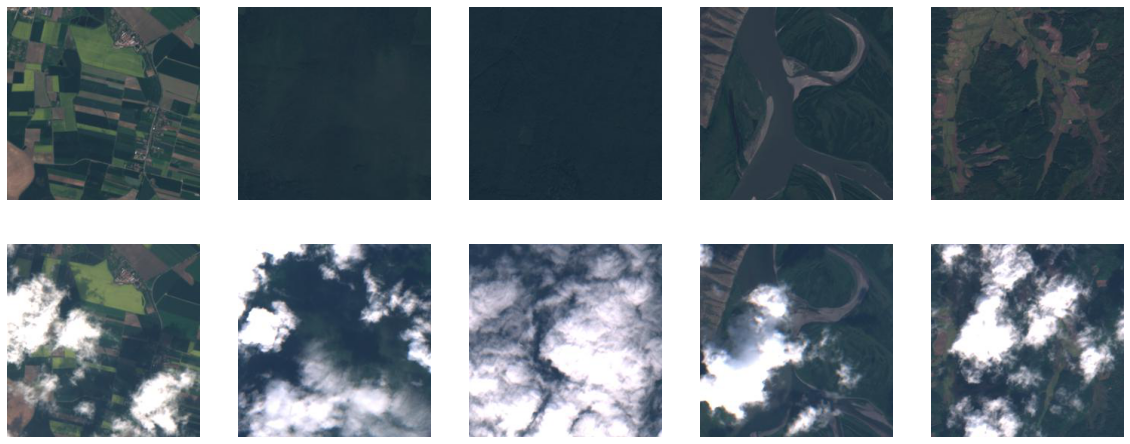

In [ ]:
show_image_pair(dataset, k)

In [ ]:
from diffusers import RePaintPipeline, RePaintScheduler

In [ ]:
# Load the RePaint scheduler and pipeline based on a pretrained DDPM model
scheduler = RePaintScheduler.from_pretrained(config.model_dir)
pipe = RePaintPipeline.from_pretrained(config.model_dir, scheduler=scheduler)
pipe = pipe.to("cuda")

The config attributes {'variance_type': 'fixed_small'} were passed to RePaintScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
generator = torch.Generator(device="cuda")

In [ ]:
img = dataset[53419]
clear, cloud, mask = img[0], img[1], Image.fromarray(np.round(np.invert(ImageOps.grayscale(img[1])) / 255) * 255)

In [ ]:
def show_imgs(clear, cloud, mask):
  fig, axs = plt.subplots(1, 3, figsize=(12, 4))
  axs[0].imshow(clear)
  axs[0].set_axis_off()
  axs[1].imshow(cloud)
  axs[1].set_axis_off()
  axs[2].imshow(mask, cmap='gray')
  axs[2].set_axis_off()
  fig.show()

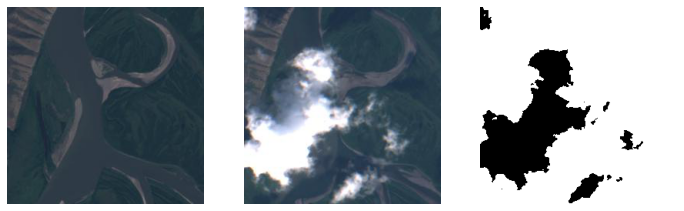

In [ ]:
show_imgs(clear, cloud, mask)

In [ ]:
output = pipe(
    image=clear,
    mask_image=mask,
    num_inference_steps=100,
    eta=0.0,
    jump_length=15,
    jump_n_sample=5,
    generator=generator,
)

  0%|          | 0/820 [00:00<?, ?it/s]

In [ ]:
inpainted_image = output.images[0]

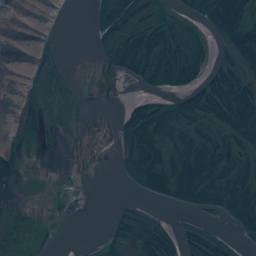

In [ ]:
inpainted_image

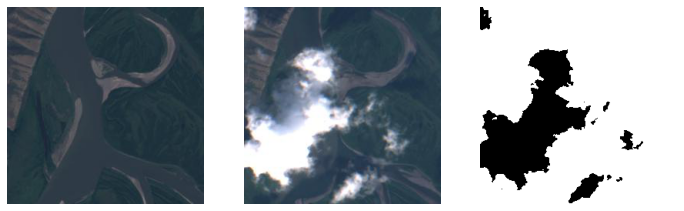

In [ ]:
show_imgs(clear, cloud, mask)

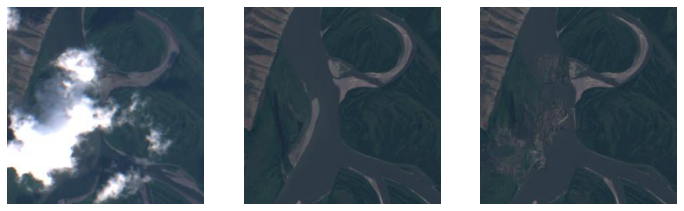

In [ ]:
show_imgs(cloud, clear, inpainted_image)

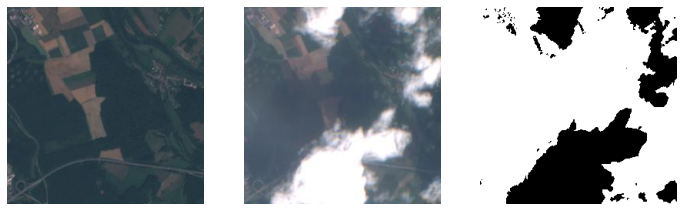

In [ ]:
show_imgs(clear, cloud, mask)

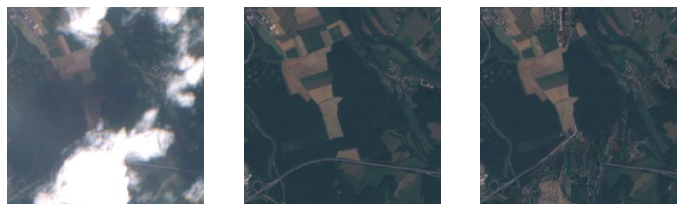

In [ ]:
show_imgs(cloud, clear, inpainted_image)

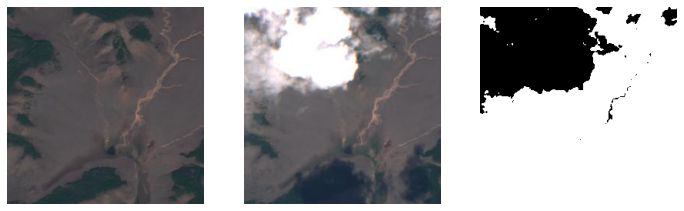

In [ ]:
show_imgs(clear, cloud, mask)

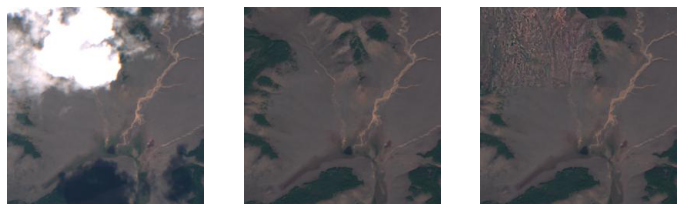

In [ ]:
show_imgs(cloud, clear, inpainted_image)

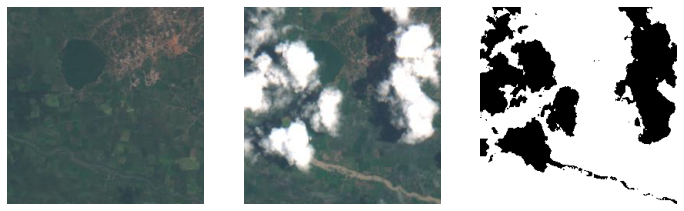

In [ ]:
show_imgs(clear, cloud, mask)

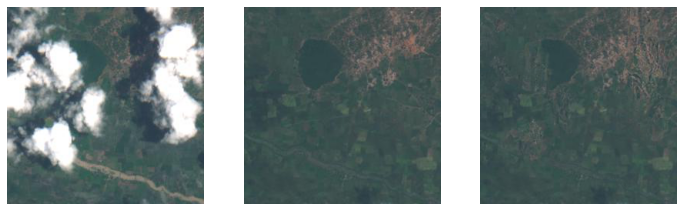

In [ ]:
show_imgs(cloud, clear, inpainted_image)

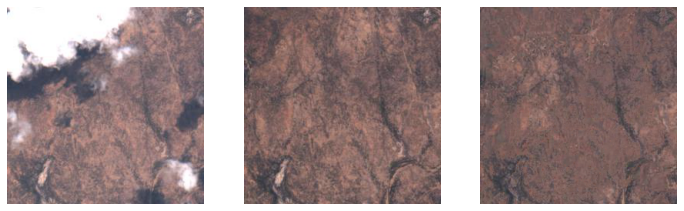

In [ ]:
show_imgs(cloud, clear, inpainted_image)

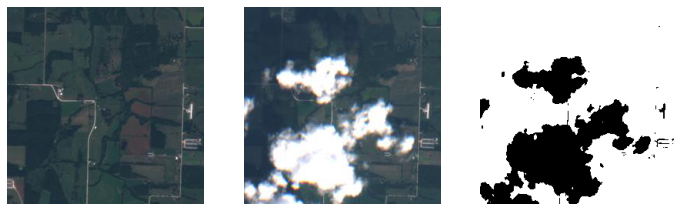

In [ ]:
show_imgs(clear, cloud, mask)

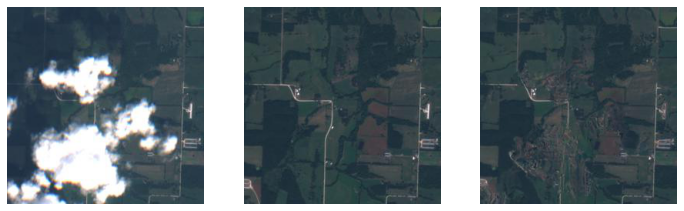

In [ ]:
show_imgs(cloud, clear, inpainted_image)

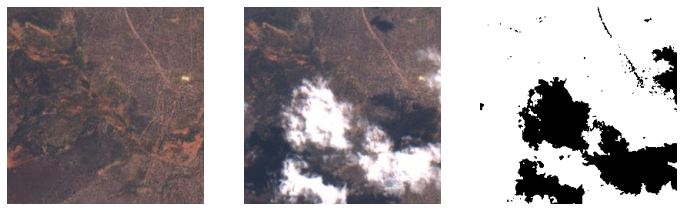

In [ ]:
show_imgs(clear, cloud, mask)

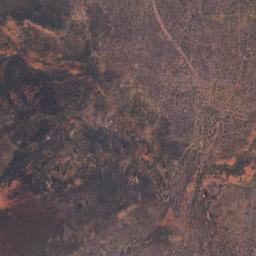

In [ ]:
inpainted_image

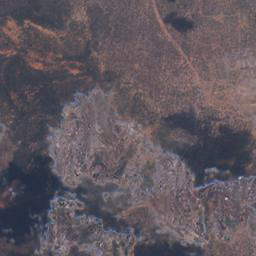

In [ ]:
inpainted_image

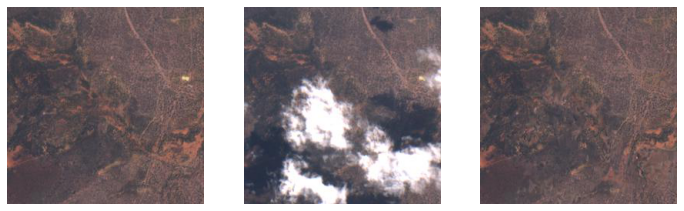

In [ ]:
show_imgs(clear, cloud, inpainted_image)

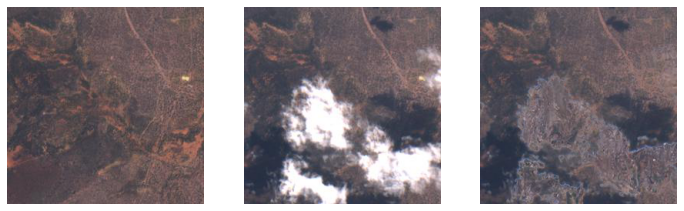

In [ ]:
show_imgs(clear, cloud, inpainted_image)

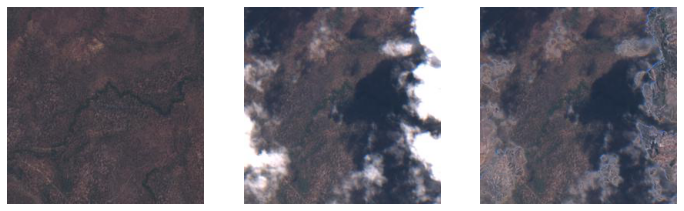

In [ ]:
show_imgs(clear, cloud, inpainted_image)

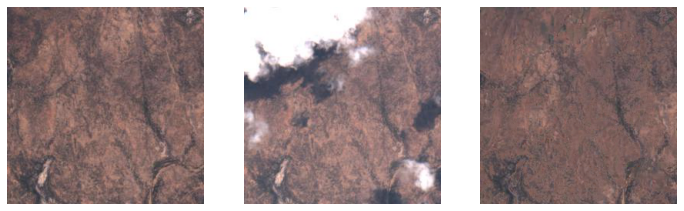

In [ ]:
show_imgs(clear, cloud, inpainted_image)

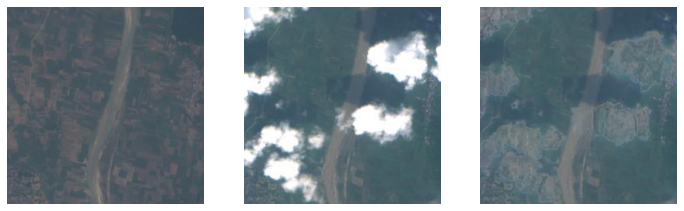

In [ ]:
show_imgs(clear, cloud, inpainted_image)

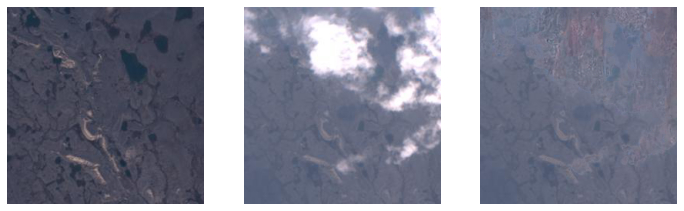

In [ ]:
show_imgs(clear, cloud, inpainted_image)

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
def get_normalized(clear, inpted):
  return np.array(clear) / 255, np.array(inpainted_image) / 255

In [ ]:
c, i = get_normalized(clear, inpainted_image)

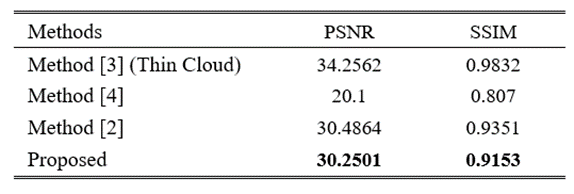

In [ ]:
print("Structural Similarity (SSIM)", ssim(c, i, multichannel=True))
print("Peak Signal Noise Ratio (PSNR)", psnr(c, i))

Structural Similarity (SSIM) 0.9153513123561526
Peak Signal Noise Ratio (PSNR) 30.250131016891242


In [ ]:
# print("Structural Similarity (SSIM)", ssim(c, i, multichannel=True))
# print("Peak Signal Noise Ratio (PSNR)", psnr(c, i))

Structural Similarity (SSIM) 0.8099427380723374
Peak Signal Noise Ratio (PSNR) 24.92185077889056
